In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from numpy.random import randint
import math
from torch.nn import functional as F
import numpy as np
import time
import pdb
from torch.autograd import grad
import copy
import shutil
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import utils
import models

In [ ]:
class opt:
    source_train_path = '/datasets/snr005/SNR005_train.h5'
    source_test_path = '/datasets/snr005/SNR005_test.h5'
    target_train_path = '/datasets/snrinfinity/SNRinfinity_train.h5'
    target_test_path = '/datasets/snrinfinity/SNRinfinity_test.h5'
    numclass = 10
    fet_size = 128
    h = 400
    nepoch = 100
    nepoch_wdgrl = 50
    cuda = True
    manualSeed = 9182
    batch_size = 32
    tomo_dim = (32,32,32)
    clfr_lr = 0.0001
    critic_iter = 1
    clfr_iter = 1
    gamma = 10
    wd_clf = 1
    save_src_clfr = "./best_model/source_clfr_snr005.pt"
    save_tar_clfr = "./best_model/target_clfr_snrinf_from_005.pt"

In [ ]:
if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
if opt.cuda:
    torch.cuda.manual_seed_all(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

Random Seed:  9182


In [ ]:
data = utils.DATA_LOADER(opt)
print("# of source training samples: ", data.source_ntrain)
print("# of source test samples: ", data.source_ntest)
print("# of target training samples: ", data.target_ntrain)
print("# of target test samples: ", data.target_ntest)
print("# of class: ", data.numclass)

# of source training samples:  4500
# of source test samples:  500
# of target training samples:  4500
# of target test samples:  500
# of class:  10


In [ ]:
source_clsfr = models.CLFR(opt)
print(source_clsfr)

CLFR(
  (conv1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv3d(64, 128, kernel_size=(2, 2, 2), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden): Sequential(
    (0): Linear(in_features=128, out

In [ ]:
cls_criterion = nn.CrossEntropyLoss()
input_tomo = torch.FloatTensor(opt.batch_size, opt.tomo_dim[0], opt.tomo_dim[1], opt.tomo_dim[2])
input_label = torch.FloatTensor(opt.batch_size)

In [ ]:
if opt.cuda :
    source_clsfr.cuda()
    cls_criterion.cuda()
    input_tomo = input_tomo.cuda()
    input_label = input_label.cuda()

In [ ]:
def sample():
    batch_tomo, batch_label = data.source_next_batch(opt.batch_size)
    input_tomo.copy_(batch_tomo)
    input_label.copy_(batch_label)

In [ ]:
optim_clfr = optim.Adam(source_clsfr.parameters(), lr=opt.clfr_lr)

In [ ]:
def calculate_accuracy(net, tomo, label):
    utils.set_requires_grad(net, requires_grad=False)
    logits = net(tomo.cuda())
    _, predicted = torch.max(logits, 1)
    c = (predicted == label.cuda()).sum()
    c = c.cpu().numpy()
    acc = c / len(label)

    return acc

In [ ]:
best_acc = 0

for epoch in range(opt.nepoch):
    for i in range(0, data.source_ntrain, opt.batch_size):

        for p in source_clsfr.parameters():
            p.requires_grad = True

        sample()
        source_clsfr.zero_grad()
        input_tomoV = Variable(input_tomo)
        input_labelV = Variable(input_label.long())

        logits = source_clsfr(input_tomoV)
        loss = cls_criterion(logits, input_labelV)
        loss.backward()
        optim_clfr.step()

    source_clsfr.eval()
    acc = calculate_accuracy(net=source_clsfr, tomo=data.source_test_subtom, label=data.source_test_label)
    print('[%d/%d] clfr_loss: %.4f | test_acc: %.4f'% (epoch, opt.nepoch, loss.item(),acc))

    if acc >= best_acc:
        print('[Source Domain]Validation Acc increased ({:.4f} --> {:.4f}).  Saving model ...'.format(best_acc,acc))
        torch.save(source_clsfr.state_dict(), opt.save_src_clfr)
        best_acc = acc

    source_clsfr.train()

[0/100] clfr_loss: 2.1424 | test_acc: 0.1200
[Source Domain]Validation Acc increased (0.0000 --> 0.1200).  Saving model ...
[1/100] clfr_loss: 1.8119 | test_acc: 0.4800
[Source Domain]Validation Acc increased (0.1200 --> 0.4800).  Saving model ...
[2/100] clfr_loss: 1.3638 | test_acc: 0.6500
[Source Domain]Validation Acc increased (0.4800 --> 0.6500).  Saving model ...
[3/100] clfr_loss: 0.8106 | test_acc: 0.7380
[Source Domain]Validation Acc increased (0.6500 --> 0.7380).  Saving model ...
[4/100] clfr_loss: 0.8746 | test_acc: 0.8120
[Source Domain]Validation Acc increased (0.7380 --> 0.8120).  Saving model ...
[5/100] clfr_loss: 0.5214 | test_acc: 0.7980
[6/100] clfr_loss: 0.4428 | test_acc: 0.8280
[Source Domain]Validation Acc increased (0.8120 --> 0.8280).  Saving model ...
[7/100] clfr_loss: 0.4045 | test_acc: 0.8000
[8/100] clfr_loss: 0.2478 | test_acc: 0.8340
[Source Domain]Validation Acc increased (0.8280 --> 0.8340).  Saving model ...
[9/100] clfr_loss: 0.3059 | test_acc: 0.82

Sat Jul 25 15:04:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |   5994MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
target_clsfr = models.CLFR(opt)
target_clsfr.load_state_dict(torch.load(opt.save_src_clfr))

<All keys matched successfully>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def gradient_penalty(critic, h_s, h_t):
    # based on: https://github.com/caogang/wgan-gp/blob/master/gan_cifar10.py#L116
    alpha = torch.rand(h_s.size(0), 1).to(device)
    differences = h_t - h_s
    interpolates = h_s + (alpha * differences)
    interpolates = torch.stack([interpolates, h_s, h_t]).requires_grad_()

    preds = critic(interpolates)
    gradients = grad(preds, interpolates,
                     grad_outputs=torch.ones_like(preds),
                     retain_graph=True, create_graph=True)[0]
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1)**2).mean()
    return gradient_penalty

In [ ]:
critic = models.CRITIC(opt)
print(critic)

CRITIC(
  (critic_block): Sequential(
    (0): Linear(in_features=128, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [ ]:
critic_optim = torch.optim.Adam(critic.parameters(), lr=1e-4)
clf_optim = torch.optim.Adam(target_clsfr.parameters(), lr=opt.clfr_lr)

In [ ]:
clf_criterion = nn.CrossEntropyLoss()
source_tomo = torch.FloatTensor(opt.batch_size, opt.tomo_dim[0], opt.tomo_dim[1], opt.tomo_dim[2])
source_label = torch.FloatTensor(opt.batch_size)
target_tomo = torch.FloatTensor(opt.batch_size, opt.tomo_dim[0], opt.tomo_dim[1], opt.tomo_dim[2])

In [ ]:
if opt.cuda :
    critic.cuda()
    target_clsfr.cuda()
    clf_criterion.cuda()
    source_tomo = source_tomo.cuda()
    source_label = source_label.cuda()
    target_tomo = target_tomo.cuda()

In [ ]:
def both_sample():
    source_batch_tomo, source_batch_label = data.source_next_batch(opt.batch_size)
    source_tomo.copy_(source_batch_tomo)
    source_label.copy_(source_batch_label)
    target_batch_tomo, _ = data.target_next_batch(opt.batch_size)
    target_tomo.copy_(target_batch_tomo)

In [ ]:
best_acc = 0

for epoch in range(opt.nepoch_wdgrl):
    for i in range(0, data.source_ntrain, opt.batch_size):
        both_sample()

        #train critic
        utils.set_requires_grad(critic, requires_grad=True)
        utils.set_requires_grad(target_clsfr, requires_grad=False)

        with torch.no_grad():
            h_s = target_clsfr.feature_extractor(source_tomo)
            h_t = target_clsfr.feature_extractor(target_tomo)
        
        for _ in range(opt.critic_iter):
            gp = gradient_penalty(critic, h_s, h_t)
            critic_s = critic(h_s)
            critic_t = critic(h_t)
            wasserstein_distance = critic_s.mean() - critic_t.mean()
            critic_cost = -wasserstein_distance + opt.gamma*gp

            critic_optim.zero_grad()
            critic_cost.backward()
            critic_optim.step()

        #train classifier
        utils.set_requires_grad(critic, requires_grad=False)
        utils.set_requires_grad(target_clsfr, requires_grad=True)

        for _ in range(opt.clfr_iter):
            source_features = target_clsfr.feature_extractor(source_tomo)
            target_features = target_clsfr.feature_extractor(target_tomo)

            source_preds = target_clsfr.classify(source_features)
            clf_loss = clf_criterion(source_preds, source_label.long())

            w_dist = critic(source_features).mean() - critic(target_features).mean()
            loss = clf_loss + opt.wd_clf*w_dist

            clf_optim.zero_grad()
            loss.backward()
            clf_optim.step()

    target_clsfr.eval()

    target_batch_tomo, target_batch_label = data.target_next_batch(100)
    tar_acc = calculate_accuracy(net=target_clsfr, tomo=target_batch_tomo, label=target_batch_label)

    print('[%d/%d] critic_cost: %.4f | w_dist: %.4f | clf_loss: %.4f | tar_acc: %.4f'% (epoch, opt.nepoch_wdgrl, critic_cost.item(), wasserstein_distance.item(), loss.item(), tar_acc))

    if tar_acc >= best_acc:
        print('[Target Domain]Validation Acc increased ({:.4f} --> {:.4f}).  Saving model ...'.format(best_acc,tar_acc))
        torch.save(target_clsfr.state_dict(), opt.save_tar_clfr)
        best_acc = tar_acc

    target_clsfr.train()

[0/50] critic_cost: 8.8807 | w_dist: -0.3444 | clf_loss: -0.3407 | tar_acc: 0.8400
[Target Domain]Validation Acc increased (0.0000 --> 0.8400).  Saving model ...
[1/50] critic_cost: 13.1331 | w_dist: -4.1738 | clf_loss: -3.7718 | tar_acc: 0.8500
[Target Domain]Validation Acc increased (0.8400 --> 0.8500).  Saving model ...
[2/50] critic_cost: 8.9397 | w_dist: 0.3677 | clf_loss: 0.7363 | tar_acc: 0.8300
[3/50] critic_cost: 9.2036 | w_dist: 0.2030 | clf_loss: 0.2996 | tar_acc: 0.8600
[Target Domain]Validation Acc increased (0.8500 --> 0.8600).  Saving model ...
[4/50] critic_cost: 9.3468 | w_dist: -0.1752 | clf_loss: -0.0796 | tar_acc: 0.8500
[5/50] critic_cost: 10.2171 | w_dist: -1.5315 | clf_loss: -1.2849 | tar_acc: 0.7800
[6/50] critic_cost: 11.5794 | w_dist: -2.4870 | clf_loss: -2.4174 | tar_acc: 0.8700
[Target Domain]Validation Acc increased (0.8600 --> 0.8700).  Saving model ...
[7/50] critic_cost: 9.6489 | w_dist: -0.1273 | clf_loss: -0.0695 | tar_acc: 0.8800
[Target Domain]Valida

In [ ]:
target_clsfr = models.CLFR(opt)
target_clsfr.load_state_dict(torch.load(opt.save_tar_clfr))
target_clsfr.cuda()

CLFR(
  (conv1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv3d(64, 128, kernel_size=(2, 2, 2), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden): Sequential(
    (0): Linear(in_features=128, out

In [ ]:
target_clsfr.eval()

CLFR(
  (conv1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv3d(64, 128, kernel_size=(2, 2, 2), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden): Sequential(
    (0): Linear(in_features=128, out

In [ ]:
acc = calculate_accuracy(net=target_clsfr, tomo=data.target_train_subtom, label=data.target_train_label)
acc

0.8433333333333334

In [ ]:
utils.set_requires_grad(target_clsfr, requires_grad=False)
logits = target_clsfr(data.target_train_subtom.cuda())
_, predicted = torch.max(logits, 1)

In [ ]:
ground_truth = data.target_train_label
pred = predicted.cpu().numpy()

In [ ]:
conf_mat = confusion_matrix(ground_truth, pred)


In [ ]:
tomo_class = ['1bxn', '1f1b', '1yg6', '2byu', '2h12', '2ldb', '3gl1', '3hhb', '4d4r', '6t3e']

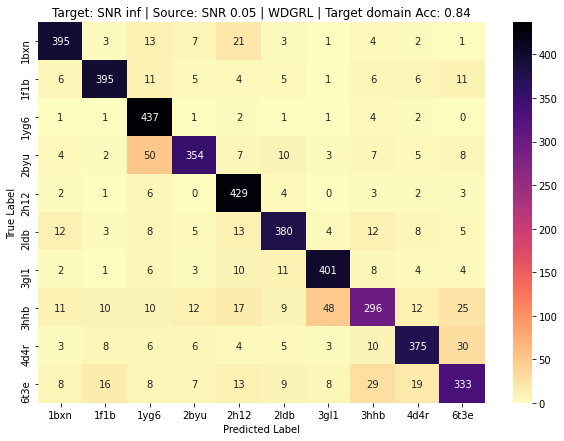

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [i for i in tomo_class],
                  columns = [i for i in tomo_class])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10},fmt="d", cmap="magma_r")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Target: SNR inf | Source: SNR 0.05 | WDGRL | Target domain Acc: {:.2f}".format(acc))
plt.savefig("./Results/src_005_tar_inf.png", bbox_inches = 'tight')